
<div align="center">
  <a href="https://www.w-hs.de/maschinenbau-master-boh/">
    <img src="https://www.w-hs.de/typo3conf/ext/whs/Resources/Public/Images/Pagelayout/w-hs_pagelogo.png" 
    alt="Images" width="500" height="200">
  </a>
</div>
<br>
<h1 align="center"> Sondergebiete der Simulation</h1>
<h3 align="center"> WS 21/22 </h3>
<br>

<br>

### Credits:

* [benmoseley](https://github.com/benmoseley/harmonic-oscillator-pinn)

In [46]:
import sympy
from sympy import symbols, Function, diff, sin, cos, Matrix, Rational, Eq, solve, lambdify
import sympy.physics.mechanics as mech
mech.init_vprinting()

### Herleitung der Bewegungsgleichungen 

Ausführliche Beschreibung der Herleitung:
[Inverted Pendulum Legrange](https://github.com/lennart2810/InvertedPendulumSDS/blob/master/MKS/Inverted%20Pendulum%20Legrange.ipynb) 

In [47]:
# symbolischen Variablen anlegen
t, l, M, m, g = symbols('t l M m g')

# Zwangsbedingung
y = 0

# generalisierte Koordinaten und deren Ableitungen:
x = Function('x')(t)
x_d = diff(x,t)
x_dd = diff(x_d,t)

theta = Function('theta')(t)
theta_d = diff(theta,t)
theta_dd = diff(theta,t,t)

# Kinematik
x2, y2 = x - l * sin(theta), y + l * cos(theta)
x2_d, y2_d = x2.diff(t), y2.diff(t)

# Legrange-Funktion
T = Rational(1,2) * M * (x_d)**2 + Rational(1,2) * m * (x2_d**2 + y2_d**2)
V = M * g * y + m * g * y2 
L = T - V

# Euler-Legrange
LE_x = diff(diff(L, x_d), t) - diff(L, x)
LE_theta = diff(diff(L, theta_d), t) - diff(L, theta)
display(Matrix([LE_x, LE_theta.simplify()]))

# Nach x_dd und theta_dd umstellen
solutions = solve([LE_x, LE_theta], (x_dd, theta_dd), simplify=True) 
sol_x_dd = Eq(x_dd-solutions[x_dd], 0)
sol_theta_dd = Eq(theta_dd - solutions[theta_dd], 0)
#display(Matrix([sol_x_dd, sol_theta_dd]))

⎡        ⎛            2                     ⎞⎤
⎢      m⋅⎝2⋅l⋅sin(θ)⋅θ̇  - 2⋅l⋅cos(θ)⋅θ̈ + 2⋅ẍ⎠⎥
⎢M⋅ẍ + ──────────────────────────────────────⎥
⎢                        2                   ⎥
⎢                                            ⎥
⎣      l⋅m⋅(-g⋅sin(θ) + l⋅θ̈ - cos(θ)⋅ẍ)      ⎦

In [48]:
# M*x_dd+0.5*m*(2*l*sin(theta)*theta_d**2-2*l*cos(theta)*theta_dd+2*x_dd)
# l*m*(-g*sin(theta)+l*theta_dd-cos(theta)*x_dd)

### Umwandlung des symbolischen Gleichungssystems in numerische Funktionen mit `sympy.lambdify`.

In [49]:
dxdt = lambdify(x_d, x_d)
dvdt = lambdify((t,g,M,m,l,theta,theta_d), solutions[x_dd])

dthetadt = lambdify(theta_d, theta_d)
domegadt = lambdify((t,g,M,m,l,theta,theta_d), solutions[theta_dd])

def dSdt(S, t, g, M, m, l):
    x, v, theta, omega = S
    return [
        dxdt(v),
        dvdt(t,g,M,m,l,theta, omega),
        dthetadt(omega),
        domegadt(t,g,M,m,l,theta,omega)
    ]

### Daten generieren

time.shape: (85,) <class 'numpy.ndarray'>
x.shape: (85,)
theta.shape: (85,)
data.shape: (85, 2)


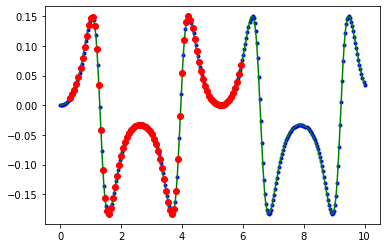

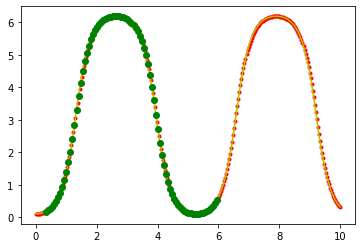

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interpolate

t1 = 10                          # s 
samples = 300                    # n 
t = np.linspace(0, t1, samples)  # s

g = 9.81                         # m/s^2
M = 5                            # kg
m = 1                            # kg
l = 1                            # m
F = 0                            # N

S0 = [0, 0, 0.1, 0]              # m, m/s, rad, rad/s

# numerische Lösung
ans = odeint(dSdt, y0=S0, t=t, args=(g, M, m, l))
x = ans.T[0]
theta = ans.T[2]

# numerische Lösung --> Lösungsfunktion interpolieren (für DeepXDE)
t_new = np.linspace(0, t1, samples+2000)    
x_f = interpolate.interp1d(t, x, 'cubic')
theta_f = interpolate.interp1d(t, theta, 'cubic')

# 'Messwerte'
a, b, i = 10, 180, 2 # jeden i. Punkt im Intervall [a,b] 
t_data = t[a:b:i]
x_data = x[a:b:i]
theta_data = theta[a:b:i]

# Data für NN zusammenfassen: (nur nötig wenn 1 Model mit 2 Outputs genutzt wird)
data = np.concatenate((x_data, theta_data)).reshape(2, len(t_data)).T
print('time.shape:', t_data.shape, type(t_data))
print('x.shape:', x_data.shape)
print('theta.shape:', theta_data.shape)
print('data.shape:', data.shape)


# Visualisierung 
plt.plot(t, x, 'b.')
plt.plot(t_new, x_f(t_new), 'g-')
plt.plot(t_data, data[:,0], 'ro') # data[:,1] --> x_data
plt.show()

plt.plot(t, theta, 'r.')
plt.plot(t_new, theta_f(t_new), 'y-')
plt.plot(t_data, data[:,1], 'go') # data[:,1] --> theta_data
plt.show()

## DeepXDE 

In [85]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch"""
import deepxde as dde
import numpy as np
from deepxde.backend import sin
import tensorflow as tf


def ode_system_ip(t, y):
    
    x, theta = y[:, 0:1], y[:, 1:]
    print(x.eval())
    plt.plot(t, y)
    
    x_d = dde.grad.jacobian(y, t, i=0)
    theta_d = dde.grad.jacobian(y, t, i=0)
    
    x_dd = dde.grad.hessian(y, t, component=0, i=0, j=0)
    theta_dd = dde.grad.hessian(y, t, component=1, i=0, j=0)
    
    sin_theta = tf.sin(theta)
    print(sin_theta)
    cos_theta = tf.cos(theta)

    #eq_x = (M+m)*x_dd - m*l*theta_dd*cos_theta + m*l*theta_d**2*sin_theta
    #eq_theta = l*theta_dd - x_dd*cos_theta - g*sin_theta
    
    # M*x_dd+0.5*m*(2*l*sin(theta)*theta_d**2-2*l*cos(theta)*theta_dd+2*x_dd)
    # l*m*(-g*sin(theta)+l*theta_dd-cos(theta)*x_dd)
    
    eq_x = M*x_dd+0.5*m*(2*l*tf.sin(theta)*theta_d**2-2*l*tf.cos(theta)*theta_dd+2*x_dd)
    eq_theta = l*m*(-g*tf.sin(theta)+l*theta_dd-tf.cos(theta)*x_dd)


    
    print('eqx', eq_x.shape, eq_x)
    print('eqtheta', eq_theta)
    
    return [eq_x, eq_theta]


def boundary(_, on_initial):
    return on_initial

def func(t):

    return np.hstack((x_f(t), theta_f(t)))


geom = dde.geometry.TimeDomain(0, t1)
#ic1 = dde.IC(geom, lambda x :0, boundary, component=0)
#ic2 = dde.IC(geom, lambda x:0.1, boundary, component=1)
ic1 = dde.IC(geom, x_f, boundary, component=0)
ic2 = dde.IC(geom, theta_f, boundary, component=1)
data = dde.data.PDE(geom, ode_system_ip, [ic1, ic2], num_domain=50, num_boundary=2, solution=func, num_test=100)

layer_size = [1] + [50] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
Building feed-forward neural network...
'build' took 0.111986 s



/Users/lennartfuhrig/opt/anaconda3/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+52=52. 
  warnings.warn("The balance properties of Sobol' points require "


ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`

# Nur Theta

Compiling model...
Building feed-forward neural network...
'build' took 0.065713 s



/Users/lennartfuhrig/opt/anaconda3/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+42=42. 
  warnings.warn("The balance properties of Sobol' points require "


'compile' took 0.955946 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [1.19e-01, 4.18e-01, 0.00e+00, 1.00e+00]    [1.21e-01, 4.27e-01, 0.00e+00, 1.00e+00]    [1.23e+00]    
1000      [9.92e-03, 7.27e-03, 4.38e-08, 2.56e-04]    [1.10e-02, 6.31e-03, 4.38e-08, 2.56e-04]    [8.56e-01]    
2000      [6.36e-03, 5.77e-03, 2.19e-08, 1.79e-04]    [6.96e-03, 5.36e-03, 2.19e-08, 1.79e-04]    [7.99e-01]    
3000      [3.89e-03, 4.41e-03, 2.33e-07, 7.91e-05]    [4.28e-03, 4.83e-03, 2.33e-07, 7.91e-05]    [6.89e-01]    
4000      [3.29e-03, 3.15e-03, 1.24e-07, 4.81e-05]    [3.58e-03, 4.01e-03, 1.24e-07, 4.81e-05]    [6.03e-01]    
5000      [2.52e-03, 2.22e-03, 2.65e-07, 2.76e-05]    [3.02e-03, 7.79e-03, 2.65e-07, 2.76e-05]    [5.91e-01]    
6000      [3.40e-05, 4.48e-05, 6.41e-09, 1.09e-07]    [1.91e-02, 3.45e-01, 6.41e-09, 1.09e-07]    [9.41e-01]    
7000      [4.71e-06, 8.5

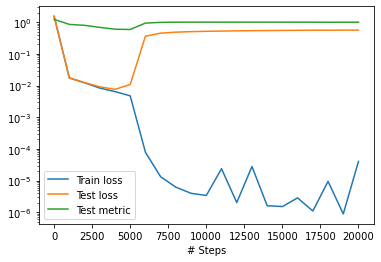

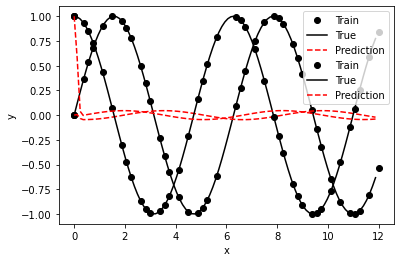

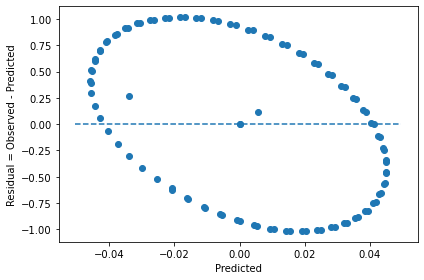

In [79]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch"""
import deepxde as dde
import numpy as np


def ode_system(x, y):
    
    
    y1, y2 = y[:, 0:1], y[:, 1:]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)
    
    r1 = dy1_x - y2
    r2 = dy2_x + y1
    
    return [r1, r2]


def boundary(_, on_initial):
    return on_initial


def func(x):
    return np.hstack((np.sin(x), np.cos(x)))


geom = dde.geometry.TimeDomain(0, 12)
ic1 = dde.IC(geom, lambda x: np.sin(0), boundary, component=0)
ic2 = dde.IC(geom, lambda x: np.cos(0), boundary, component=1)
data = dde.data.PDE(geom, ode_system, [ic1, ic2], 40, 2, solution=func, num_test=100)

layer_size = [1] + [50] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=20000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
Building feed-forward neural network...
'build' took 0.057546 s



/Users/lennartfuhrig/opt/anaconda3/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+37=37. 
  warnings.warn("The balance properties of Sobol' points require "


'compile' took 0.379452 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [2.63e-01, 1.84e-01, 0.00e+00, 1.00e+00]    [2.67e-01, 1.87e-01, 0.00e+00, 1.00e+00]    [1.18e+00]    
1000      [8.04e-03, 7.34e-03, 7.59e-08, 3.05e-04]    [8.83e-03, 6.79e-03, 7.59e-08, 3.05e-04]    [7.63e-01]    
2000      [6.48e-03, 7.43e-03, 3.79e-06, 1.16e-05]    [6.88e-03, 7.54e-03, 3.79e-06, 1.16e-05]    [5.33e-01]    
3000      [1.55e-03, 1.96e-03, 1.84e-06, 2.60e-05]    [1.84e-03, 1.76e-03, 1.84e-06, 2.60e-05]    [3.18e-01]    
4000      [3.51e-04, 6.53e-04, 2.93e-07, 1.08e-05]    [4.04e-04, 5.27e-04, 2.93e-07, 1.08e-05]    [1.42e-01]    
5000      [1.12e-04, 2.08e-04, 4.07e-05, 1.35e-05]    [1.06e-04, 2.24e-04, 4.07e-05, 1.35e-05]    [3.37e-02]    
6000      [3.43e-05, 1.19e-05, 7.61e-07, 1.10e-07]    [3.03e-05, 1.13e-05, 7.61e-07, 1.10e-07]    [1.28e-02]    
7000      [1.95e-05, 5.1

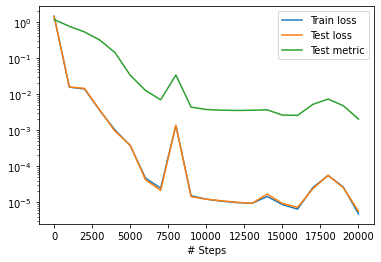

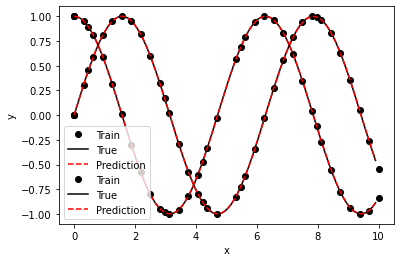

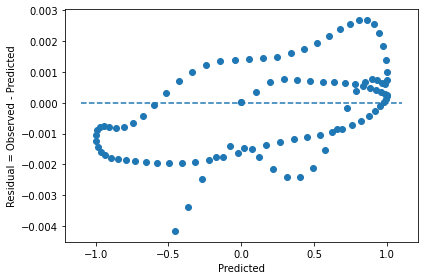

In [25]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch"""
import deepxde as dde
import numpy as np


def ode_system(x, y):
    """ODE system.
    dy1/dx = y2
    dy2/dx = -y1
    """
    y1, y2 = y[:, 0:1], y[:, 1:]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)
    return [dy1_x - y2, dy2_x + y1]


def boundary(_, on_initial):
    return on_initial


def func(x):
    return np.hstack((np.sin(x), np.cos(x)))


geom = dde.geometry.TimeDomain(0, 10)
ic1 = dde.IC(geom, np.sin, boundary, component=0)
ic2 = dde.IC(geom, np.cos, boundary, component=1)
data = dde.data.PDE(geom, ode_system, [ic1, ic2], 35, 2, solution=func, num_test=100)

layer_size = [1] + [50] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=20000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
Building feed-forward neural network...
'build' took 0.057932 s

'compile' took 0.607917 s

Initializing variables...
Training model...

Step      Train loss    Test loss     Test metric   
0         [1.65e+01]    [1.67e+01]    [9.99e-01]    
1000      [9.21e+00]    [9.19e+00]    [7.41e-01]    
2000      [5.50e+00]    [5.62e+00]    [5.79e-01]    
3000      [5.39e+00]    [5.51e+00]    [5.74e-01]    
4000      [5.38e+00]    [5.48e+00]    [5.72e-01]    
5000      [5.38e+00]    [5.47e+00]    [5.71e-01]    
6000      [5.38e+00]    [5.47e+00]    [5.71e-01]    
7000      [5.38e+00]    [5.47e+00]    [5.71e-01]    
8000      [5.39e+00]    [5.47e+00]    [5.71e-01]    
9000      [5.38e+00]    [5.46e+00]    [5.71e-01]    
10000     [5.38e+00]    [5.46e+00]    [5.71e-01]    
11000     [5.38e+00]    [5.46e+00]    [5.71e-01]    
12000     [5.38e+00]    [5.46e+00]    [5.71e-01]    
13000     [5.38e+00]    [5.46e+00]    [5.71e-01]    
14000     [5.38e+00]    [5.47e+00]    [5.71e-01] 

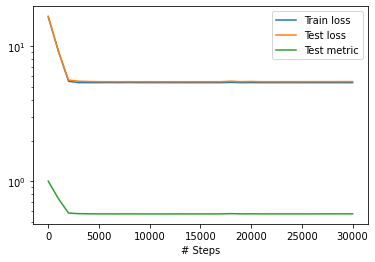

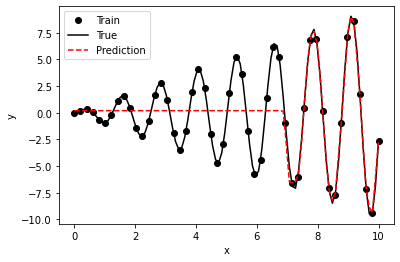

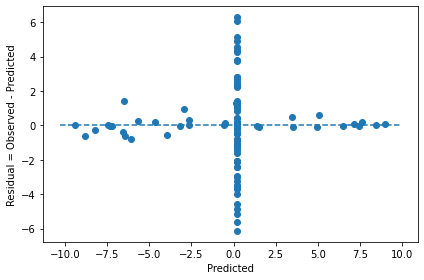

In [61]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch"""
import deepxde as dde
import numpy as np


def func(x):
    """
    x: array_like, N x D_in
    y: array_like, N x D_out
    """
    return x * np.sin(5 * x)


geom = dde.geometry.Interval(0, 10)
num_train = 50
num_test = 100
data = dde.data.Function(geom, func, num_train, num_test)

activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN([1] + [20] * 3 + [1], activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=30000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)